In [10]:
! pip install librosa tqdm


In [1]:
import os
import librosa
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [3]:
def extract_features(file_path):
    audio,sr=librosa.load(file_path,res_type='kaiser_fast')
    mfccs=librosa.feature.mfcc(y=audio,sr=sr,n_mfcc=40)
    return np.mean(mfccs.T,axis=0)

In [4]:
features=[]
labels=[]
dataset_path = r"./"
for actorfolder in tqdm(os.listdir(dataset_path)):
    actor_path = os.path.join(dataset_path,actorfolder)

    if  not  os.path.isdir(actor_path) or not actorfolder.startswith("Actor_"):
        continue
    for file in  os.listdir(actor_path):
        if file.lower().endswith(".wav"):
            emotion_code = file.split("-")[2]
            emotion = emotion_map.get(emotion_code)
            if emotion:
                try:
                    file_path = os.path.join(actor_path, file)
                    mfcc = extract_features(file_path)
                    features.append(mfcc)
                    labels.append(emotion)
                except Exception as e:
                    print(f"Error processing {file}: {e}")


  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:53<00:00,  2.16s/it]


In [6]:
X = np.array(features)
y = np.array(labels)


In [7]:
print(X)
print(y)

[[-592.5197      55.269863   -19.240614  ...    3.9826357    8.654726
    11.515515 ]
 [-571.7712      53.82124    -19.770306  ...    4.2246065    9.785755
    11.845788 ]
 [-579.2167      54.23281    -15.242693  ...    5.6024175    9.031712
     9.748875 ]
 ...
 [-481.15634     35.786465   -17.89186   ...    1.0757055    3.3618574
     3.96783  ]
 [-466.1816      33.51011    -12.885957  ...    2.2779536    2.7800336
     2.2530189]
 [-469.51636     24.24842    -13.960223  ...    1.0448917    1.6230707
     5.739345 ]]
['neutral' 'neutral' 'neutral' ... 'fearful' 'fearful' 'fearful']


In [8]:
import pandas as  pd
df = pd.DataFrame(X)
df['label'] = y
df.to_csv('ravdess_features.csv', index=False)

In [9]:
df.shape

(1012, 41)

In [10]:
df.isna().sum()

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
30       0
31       0
32       0
33       0
34       0
35       0
36       0
37       0
38       0
39       0
label    0
dtype: int64

In [11]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,label
0,-592.519714,55.269863,-19.240614,14.985034,-4.303793,-0.782968,-15.683035,-4.746462,-22.302803,-5.347614,...,-6.584931,-2.434463,-3.743651,-0.299833,1.267962,5.327147,3.982636,8.654726,11.515515,neutral
1,-571.771179,53.821239,-19.770306,14.672212,-3.221300,-2.219379,-15.660699,-4.115021,-21.762812,-0.923149,...,-6.433335,-2.461544,-4.143042,0.553830,1.998689,5.020371,4.224607,9.785755,11.845788,neutral
2,-579.216675,54.232811,-15.242693,17.250660,-4.751227,0.021345,-13.251751,-5.477705,-20.139534,-4.198606,...,-5.051621,-1.963996,-3.542640,-0.745385,1.221582,3.439565,5.602417,9.031712,9.748875,neutral
3,-581.090637,53.249722,-19.030127,17.035286,-5.648746,1.875090,-16.216503,-5.108720,-21.046431,-2.953223,...,-5.261817,-2.072452,-4.843050,0.880779,1.297034,4.160462,5.900162,9.407314,10.992938,neutral
4,-592.520569,61.175182,-16.242025,16.972326,-1.740968,-0.389398,-15.755614,-1.111939,-19.680889,-3.488038,...,2.623967,3.312066,-4.676118,-4.766972,-4.045164,1.991833,5.520200,10.280448,11.302134,calm


In [12]:
df['label'].value_counts()

label
calm       184
happy      184
angry      184
sad        184
fearful    184
neutral     92
Name: count, dtype: int64

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from keras.utils import to_categorical


X = df.drop('label', axis=1)
y = df['label']

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)


In [24]:
num_classes = y_categorical.shape[1]
input_shape = X.shape[1]
print(num_classes)
print(input_shape)

6
40


In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
model = Sequential([
    Dense(256, activation='relu', input_shape=(input_shape,)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

C:\Users\HAI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        10,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,038 (203.27 KB)

 Trainable params: 52,038 (203.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2317 - loss: 1.7856 - val_accuracy: 0.5172 - val_loss: 1.3937
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4683 - loss: 1.4282 - val_accuracy: 0.7143 - val_loss: 1.0198
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5453 - loss: 1.0989 - val_accuracy: 0.7635 - val_loss: 0.7266
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6467 - loss: 0.8873 - val_accuracy: 0.8030 - val_loss: 0.5823
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6933 - loss: 0.7301 - val_accuracy: 0.8030 - val_loss: 0.4998
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7183 - loss: 0.6941 - val_accuracy: 0.8227 - val_loss: 0.4488
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8028 - loss: 0.5213 - val_accuracy: 0.8325 - val_loss: 0.4085
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7989 - loss: 0.5131 - val_accuracy: 0.8621 - val_lo

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8695 - loss: 0.4429 
Test Accuracy: 0.89


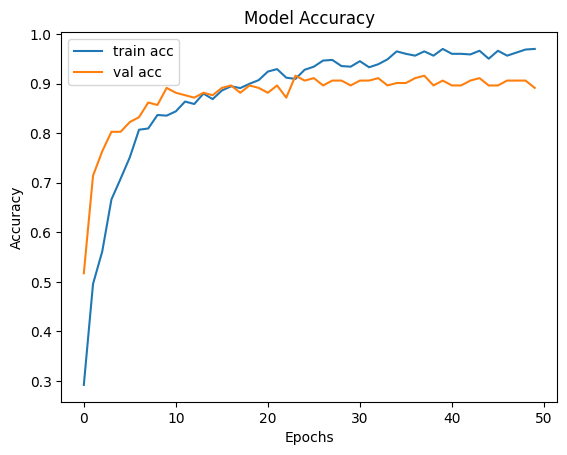

In [20]:
import matplotlib.pyplot as plt

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Plot accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [22]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8695 - loss: 0.4429
Test Loss: 0.3573397099971771
Test Accuracy: 0.8916256427764893
